# Segmentation of plant leafs using OpenCV

In this notebook I present code snippets form my scrpits with output images.
First we import used libraries and read the image.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline


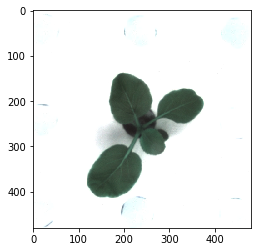

In [3]:
img = cv2.imread('multi_plant/rgb_01_02_006_05.png')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(img)


Next step is image threshold using HSV range. Next binary image is presented.

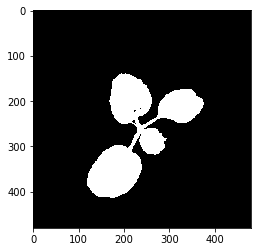

In [4]:
low_green = np.array([35, 44, 25])
high_green = np.array([73, 255, 255])
green_mask = cv2.inRange(hsv, low_green, high_green)
plt.imshow(green_mask, cmap=plt.get_cmap('gray'))


Next I'm extracting biggest contour, becouse some images contain garbage not filtered by HSV range.

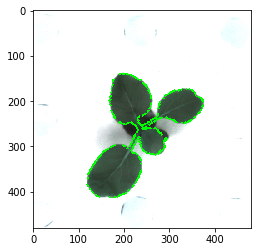

In [5]:
# extract contours
img_cont = img.copy()
contours, hierarchy = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cont_max = max(contours, key=cv2.contourArea)
cv2.drawContours(img_cont, cont_max, -1, (0, 255, 0), 3)
empty = np.zeros(green_mask.shape)
# draw filled plant
cv2.fillPoly(empty, pts=[cont_max], color=(255, 255, 255))
empty = empty.astype('uint8')
plt.imshow(img_cont)
# plt.imshow(empty,cmap='gray')

Bounding box of the plant

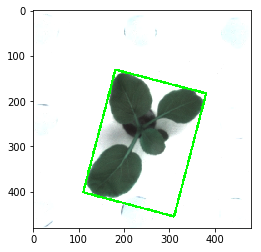

In [6]:
 # bounding box
img_box = img.copy()
rect = cv2.minAreaRect(cont_max)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img_box, [box], -1, (0, 255, 0), 3)
plt.imshow(img_box)

Next steps are the actual segmentation, in that case I'm using Watershed Alghoritm as presented here: 
https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html First step is noise removal (in that case I've set iterations at 1, previous steps filtered noise well and more is not necessary. Second step is Sure background area retreival using dilate,dilatation makes the object in white bigger.

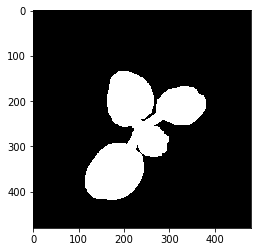

In [11]:
# WATERSHED
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(empty, cv2.MORPH_OPEN, kernel, iterations=1)
# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=5)
plt.imshow(sure_bg, cmap='gray')


Next step is finding foreground are using distance Transform

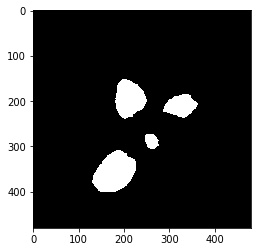

In [13]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.25 * dist_transform.max(), 255, 0)
plt.imshow(sure_fg, cmap='gray')

Next we are finding the intersenction of both areas for Watershed alghoritm.

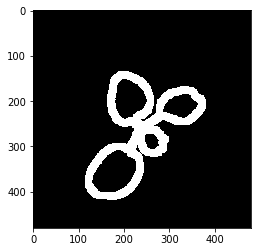

In [16]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown,cmap='gray')

Next step is extracting the actual areas with unique labels and then plotting them on image.

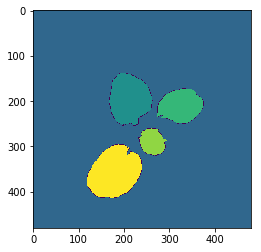

In [15]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1
# Now, mark the region of unknown with zero
markers[unknown == 255] = 0
markers = cv2.watershed(img, markers)
plt.imshow(markers)


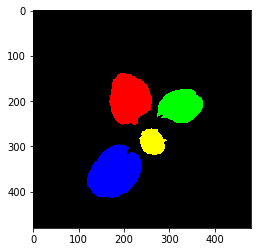

In [24]:
from colors import colors
img[markers < 2] = [0, 0, 0]
if np.unique(markers).__len__()-2 <= 7:
    for i in range(0, 7):
        img[markers == i+2] = colors[i]
else:
    for i in range(0, np.unique(markers).__len__()-2):
        img[markers == i+2] = [
            randint(0, 255), randint(0, 255), randint(0, 255)]
plt.imshow(img)
